## In Search of the Fourth Wave

Copyright 2020 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
def normalize(ys):
    low, high = np.min(ys), np.max(ys)
    return (ys - low) / (high - low)

def unbias(ys):
    return ys - ys.mean()

In [76]:
PI2 = 2 * np.pi

def eval_sine(cycles):
    return np.sin(PI2 * cycles)

In [139]:
def make_signal(duration, func, freq=1000, framerate=20000):
    """
    """
    dt = 1 / framerate
    ts = np.arange(0, duration, dt)
    cycles = freq * ts
    
    ys = func(cycles)
    
    ys = unbias(normalize(ys))
    series = pd.Series(ys, ts)
    series.dt = dt
    return series

In [140]:
sine_wave = make_signal(0.01, eval_sine)
len(sine_wave)

200

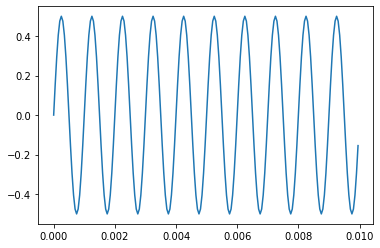

In [141]:
sine_wave.plot()

In [142]:
def make_spectrum(wave):
    n = len(wave)
    dt = wave.dt

    hs = np.fft.rfft(wave)
    fs = np.fft.rfftfreq(n, dt)

    series = pd.Series(hs, fs)
    return series

In [143]:
sine_spectrum = make_spectrum(sine_wave)
len(sine_spectrum)

101

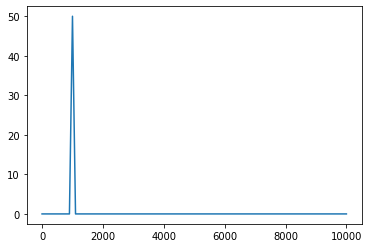

In [144]:
sine_spectrum.abs().plot()

## Sawtooth wave

In [145]:
def eval_sawtooth(cycles):
    frac, _ = np.modf(cycles)
    return frac

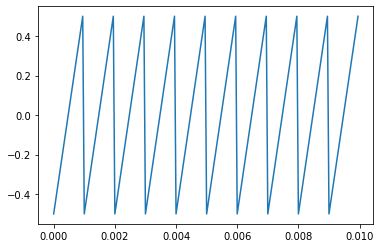

In [146]:
sawtooth_wave = make_signal(0.01, eval_sawtooth)
sawtooth_wave.plot()

In [147]:
sawtooth_spectrum = make_spectrum(sawtooth_wave)
len(sawtooth_spectrum)

101

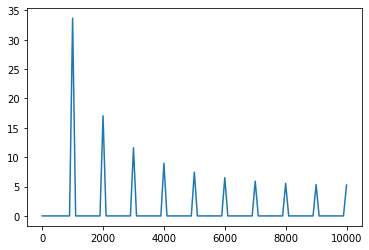

In [148]:
sawtooth_spectrum.abs().plot()

## Triangle wave

In [149]:
def eval_triangle(cycles):
    frac, _ = np.modf(cycles)
    return np.abs(frac - 0.5)

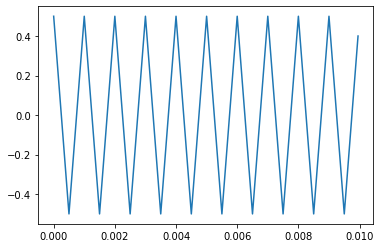

In [150]:
triangle_wave = make_signal(0.01, eval_triangle)
triangle_wave.plot()

In [151]:
triangle_spectrum = make_spectrum(triangle_wave)
len(triangle_spectrum)

101

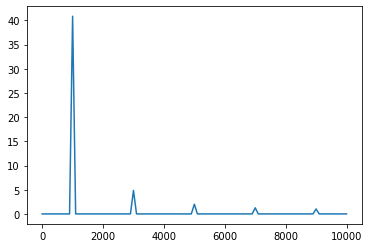

In [152]:
triangle_spectrum.abs().plot()

In [153]:
def eval_square(cycles):
    frac, _ = np.modf(cycles)
    return np.sign(frac - 0.5)

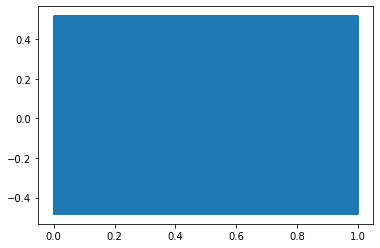

In [157]:
square_wave = make_signal(1, eval_square)
square_wave.plot()

In [158]:
square_spectrum = make_spectrum(square_wave)
len(square_spectrum)

10001

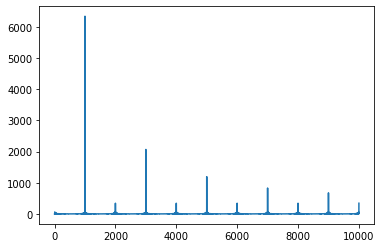

In [159]:
square_spectrum.abs().plot()

### Exercise 5

The triangle and square waves have odd harmonics only; the sawtooth wave has both even and odd harmonics. The harmonics of the square and sawtooth waves drop off in proportion to $1/f$; the harmonics of the triangle wave drop off like $1/f^2$. Can you find a waveform that has even and odd harmonics that drop off like $1/f^2$?

Hint: There are two ways you could approach this: you could
construct the signal you want by adding up sinusoids, or you
could start with a signal that is similar to what you want and
modify it.

### Solution

One option is to start with a sawtooth wave, which has all of the harmonics we need:

In [19]:
freq = 500
signal = SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the spectrum looks like.  The harmonics drop off like $1/f$.

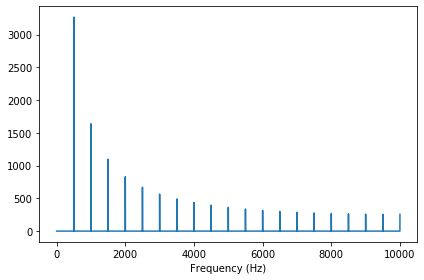

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

If we apply the filter we wrote in the previous exercise, we can make the harmonics drop off like $1/f^2$.

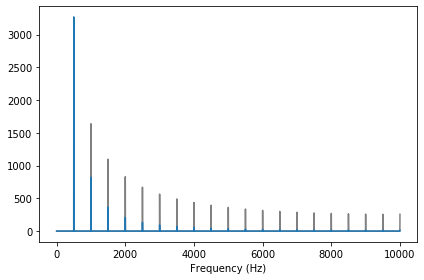

In [21]:
spectrum.plot(color='gray')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Here's what it sounds like:

In [22]:
wave = spectrum.make_wave()
wave.make_audio()

And here's what the waveform looks like.

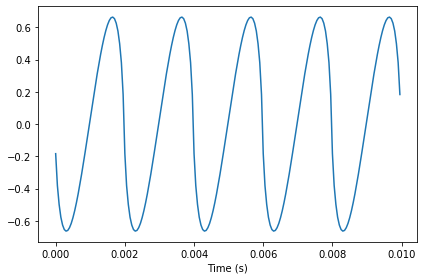

In [23]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

It's an interesting shape, but not easy to see what its functional form is.

Another approach is to add up a series of cosine signals with the right frequencies and amplitudes.

In [24]:
from thinkdsp import CosSignal

freqs = np.arange(500, 9500, 500)
amps = 1 / freqs**2
signal = sum(CosSignal(freq, amp) for freq, amp in zip(freqs, amps))
signal

Here's what the spectrum looks like:

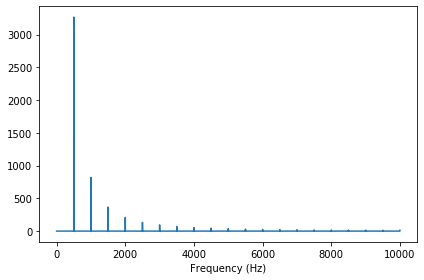

In [25]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Here's what it sounds like:

In [26]:
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

And here's what the waveform looks like.

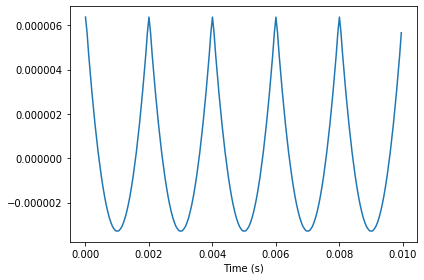

In [27]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

If you think those like parabolas, you might be right.  `thinkdsp` provides `ParabolicSignal`, which computes parabolic waveforms.

In [28]:
from thinkdsp import ParabolicSignal

wave = ParabolicSignal(freq=500).make_wave(duration=0.5, framerate=20000)
wave.make_audio()

Here's what the waveform looks like:

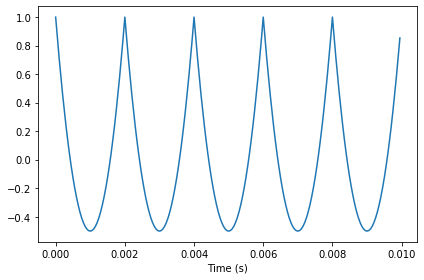

In [29]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

A parabolic signal has even and odd harmonics which drop off like $1/f^2$:

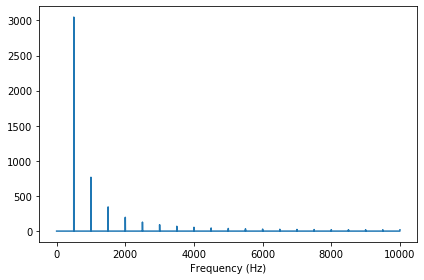

In [30]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')